   Month    Verdi
0     01   105.40
1     02    17.93
2     03    39.30
3     04   645.10
4     05   841.80
5     06  1001.83
6     07  1350.67
7     08   591.40
8     09   158.60
9     10    31.00
10    11    82.30
11    12    80.50
      Month     Verdi
0   2023-07  19666.60
1   2023-08  22179.00
2   2023-09  23088.59
3   2023-10  24014.93
4   2023-11  27018.01
5   2023-12  30256.40
6   2024-01  31376.90
7   2024-02  24775.56
8   2024-03  22963.60
9   2024-04  19065.40
10  2024-05  16361.70
11  2024-06  17280.80
12  2024-07  20978.30
13  2024-08  23460.90
14  2024-09   3205.70


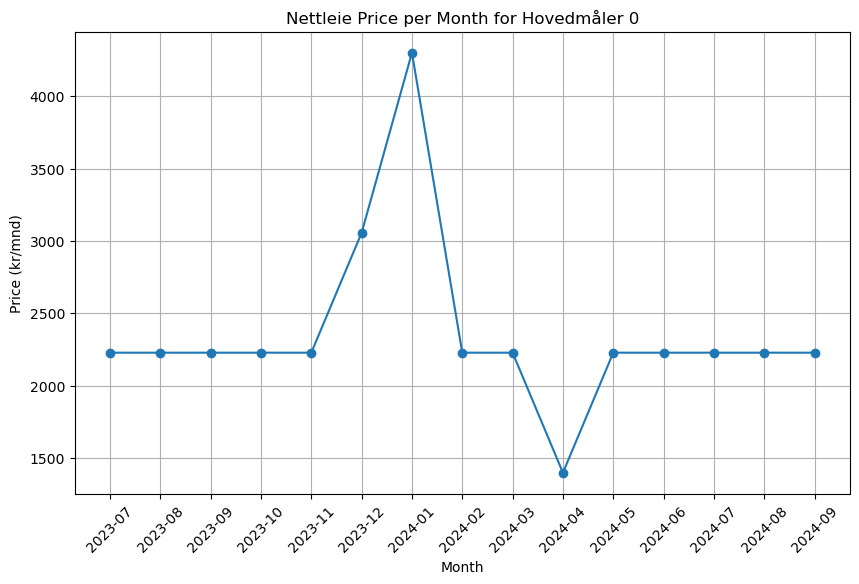

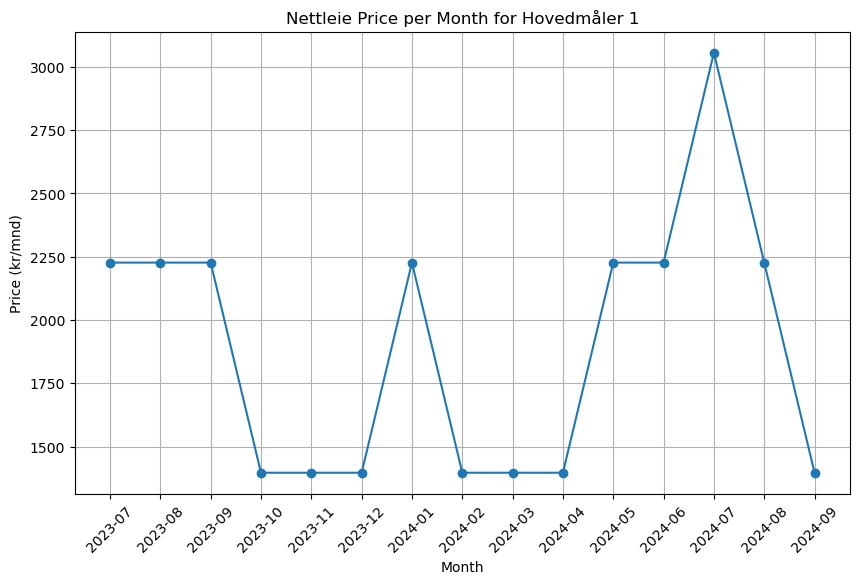

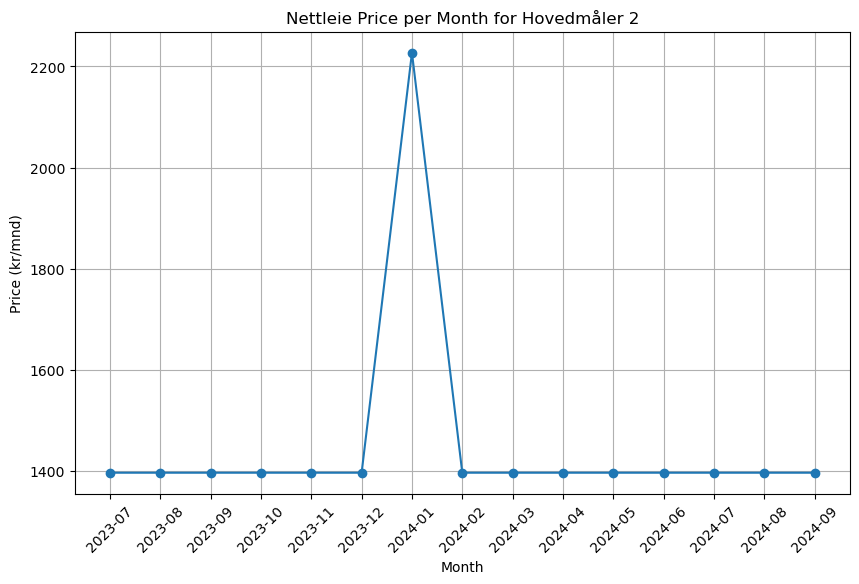

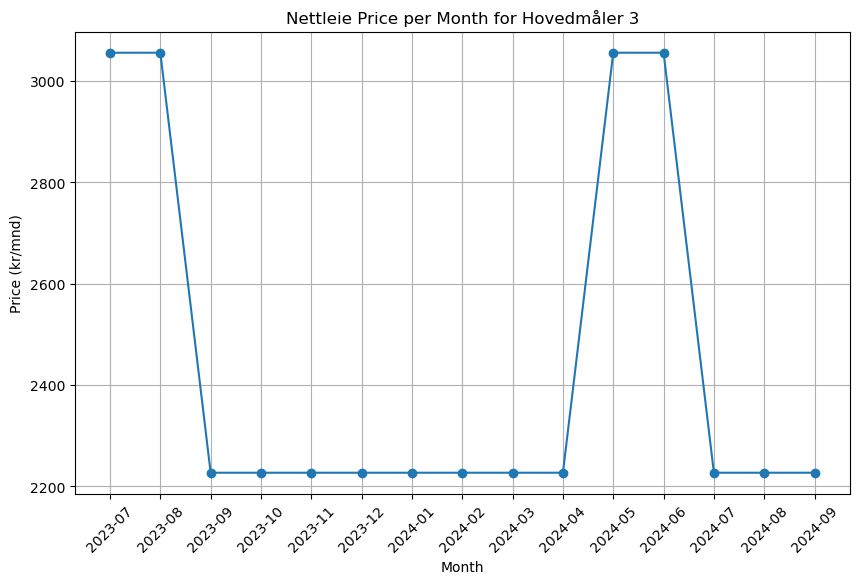

The sum for Tariff Main building: 35478
The sum for building 1: 28424
The sum for building 2: 21785
The sum for building 3: 36721


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

energy_import_export = pd.read_csv('energy_import_export.csv')
solar_self_consumption_main_building = pd.read_csv('solar_self_consumption_main_building.csv')
timeseries_met_data = pd.read_csv('timeseries_met_data_202409050822.csv')



hovedmaler_0 = energy_import_export[energy_import_export['Måler-Id'] == 0]
hovedmaler_1 = energy_import_export[energy_import_export['Måler-Id'] == 1]
hovedmaler_2 = energy_import_export[energy_import_export['Måler-Id'] == 2]
hovedmaler_3 = energy_import_export[energy_import_export['Måler-Id'] == 3]

# Assuming your energy_import_export data has already been loaded and 'Tidspunkt' is already in datetime format
# Filter the data for each Hovedmåler where 'Retning' is 'IMPORT'
hovedmaler_0_import = hovedmaler_0[hovedmaler_0['Retning'] == 'IMPORT'].copy()
hovedmaler_1_import = hovedmaler_1[hovedmaler_1['Retning'] == 'IMPORT'].copy()
hovedmaler_2_import = hovedmaler_2[hovedmaler_2['Retning'] == 'IMPORT'].copy()
hovedmaler_3_import = hovedmaler_3[hovedmaler_3['Retning'] == 'IMPORT'].copy()

hovedmaler_0_export = hovedmaler_0[hovedmaler_0['Retning'] == 'EXPORT'].copy()
hovedmaler_1_export = hovedmaler_1[hovedmaler_1['Retning'] == 'EXPORT'].copy()
hovedmaler_2_export = hovedmaler_2[hovedmaler_2['Retning'] == 'EXPORT'].copy()
hovedmaler_3_export = hovedmaler_3[hovedmaler_3['Retning'] == 'EXPORT'].copy()

"""
print(energy_import_export)
print(hovedmaler_0)
print(hovedmaler_0_export)
print(energy_import_export.iloc[60, 4])
"""

# month to electricity price of 2023 
electricity_prices_2023 = {
    '01': 158.23,
    '02': 143.69,
    '03': 140.79,
    '04': 138.67,
    '05': 100.83,
    '06': 120.56,
    '07': 85.84,
    '08': 91.13,
    '09': 71.99,
    '10': 63.12,
    '11': 130.96,
    '12': 113.67
}


# Function to add a column that multiplies 'Verdi' by the electricity price for the corresponding month
def apply_electricity_price(df, electricity_prices):
    # Convert 'Tidspunkt' to datetime format
    df['Tidspunkt'] = pd.to_datetime(df['Tidspunkt'])
    
    # Extract the month (formatted as '07', '08', etc.) from 'Tidspunkt'
    df['Month'] = df['Tidspunkt'].dt.strftime('%m')
    
    # Map the extracted month to the corresponding electricity price
    df['Electricity Price (kr/kWh)'] = df['Month'].map(electricity_prices)
    
    # Multiply 'Verdi' by the mapped electricity price
    df['Verdi * Price (kr)'] = df['Verdi'] * df['Electricity Price (kr/kWh)']
    
    return df

hovedmaler_0_import_price = apply_electricity_price(hovedmaler_0_import, electricity_prices_2023)
hovedmaler_1_import_price = apply_electricity_price(hovedmaler_1_import, electricity_prices_2023)
hovedmaler_2_import_price = apply_electricity_price(hovedmaler_2_import, electricity_prices_2023)
hovedmaler_3_import_price = apply_electricity_price(hovedmaler_3_import, electricity_prices_2023)

hovedmaler_0_export_price = apply_electricity_price(hovedmaler_0_export, electricity_prices_2023)
hovedmaler_1_export_price = apply_electricity_price(hovedmaler_1_export, electricity_prices_2023)
hovedmaler_2_export_price = apply_electricity_price(hovedmaler_2_export, electricity_prices_2023)
hovedmaler_3_export_price = apply_electricity_price(hovedmaler_3_export, electricity_prices_2023)





# Nettleie table
nettleie_table = {
    'Range': ["Fra 0 til 5 kW", "Fra 5 til 10 kW", "Fra 10 til 15 kW", "Fra 15 til 20 kW",
              "Fra 20 til 25 kW", "Fra 25 til 50 kW", "Fra 50 til 75 kW", "Fra 75 til 100 kW",
              "Fra 100 til 150 kW", "Fra 150 til 200 kW", "Fra 200 kW"],
    'Upper Bound': [5, 10, 15, 20, 25, 50, 75, 100, 150, 200, np.inf],
    'Price (kr/mnd)': [235, 402, 566, 733, 899, 1397, 2227, 3056, 4301, 5960, 8450]
}




# Function to calculate the max value per day and return the average of the top 3 highest values per month
def calculate_top3_avg_per_month(df):
    # Ensure 'Tidspunkt' is in datetime format
    df['Tidspunkt'] = pd.to_datetime(df['Tidspunkt'])
    
    # Extract day and month
    df['Day'] = df['Tidspunkt'].dt.date
    df['Month'] = df['Tidspunkt'].dt.to_period('M')

    # Group by day to get the maximum value for each day
    daily_max = df.groupby(['Month', 'Day'])['Verdi'].max().reset_index()

    # For each month, find the top 3 highest values and calculate their average
    top3_avg_per_month = daily_max.groupby('Month')['Verdi'].apply(lambda x: x.nlargest(3).mean()).reset_index()

    return top3_avg_per_month

# Now, apply the top3_avg calculation for each filtered Hovedmåler
top3_avg_hovedmaler_0 = calculate_top3_avg_per_month(hovedmaler_0_import)
top3_avg_hovedmaler_1 = calculate_top3_avg_per_month(hovedmaler_1_import)
top3_avg_hovedmaler_2 = calculate_top3_avg_per_month(hovedmaler_2_import)
top3_avg_hovedmaler_3 = calculate_top3_avg_per_month(hovedmaler_3_import)


# Create a DataFrame from the electricity prices dictionary
electricity_df = pd.DataFrame(list(electricity_prices_2023.items()), columns=['Month', 'Electricity Price (kr/kWh)'])

# Convert the Nettleie table to a DataFrame
nettleie_df = pd.DataFrame(nettleie_table)

# Function to match the average value to the Nettleie price range
def match_nettleie_price(avg_value, nettleie_df):
    for i, upper_bound in enumerate(nettleie_df['Upper Bound']):
        if avg_value <= upper_bound:
            return nettleie_df['Price (kr/mnd)'][i]
    return None

# Apply the price matching for each month in Hovedmåler 0

top3_avg_hovedmaler_0['Price (kr/mnd)'] = top3_avg_hovedmaler_0['Verdi'].apply(lambda x: match_nettleie_price(x, nettleie_df))
top3_avg_hovedmaler_1['Price (kr/mnd)'] = top3_avg_hovedmaler_1['Verdi'].apply(lambda x: match_nettleie_price(x, nettleie_df))
top3_avg_hovedmaler_2['Price (kr/mnd)'] = top3_avg_hovedmaler_2['Verdi'].apply(lambda x: match_nettleie_price(x, nettleie_df))
top3_avg_hovedmaler_3['Price (kr/mnd)'] = top3_avg_hovedmaler_3['Verdi'].apply(lambda x: match_nettleie_price(x, nettleie_df))

hovedmaler_0_import_price = hovedmaler_0_import.groupby('Month')['Verdi'].sum().reset_index()
hovedmaler_1_import_price = hovedmaler_1_import.groupby('Month')['Verdi'].sum().reset_index()
hovedmaler_2_import_price = hovedmaler_2_import.groupby('Month')['Verdi'].sum().reset_index()
hovedmaler_3_import_price = hovedmaler_3_import.groupby('Month')['Verdi'].sum().reset_index()


hovedmaler_0_export_price = hovedmaler_0_export.groupby('Month')['Verdi'].sum().reset_index()
hovedmaler_1_export_price = hovedmaler_1_export.groupby('Month')['Verdi'].sum().reset_index()
hovedmaler_2_export_price = hovedmaler_2_export.groupby('Month')['Verdi'].sum().reset_index()
hovedmaler_3_export_price = hovedmaler_3_export.groupby('Month')['Verdi'].sum().reset_index()
print(hovedmaler_0_export_price)
print(hovedmaler_0_import_price)

"""
total_0_price = hovedmaler_0_import_price - hovedmaler_0_export_price + top3_avg_hovedmaler_0['Price (kr/mnd)']
total_1_price = hovedmaler_1_import_price - hovedmaler_1_export_price + top3_avg_hovedmaler_1['Price (kr/mnd)']
total_2_price = hovedmaler_2_import_price - hovedmaler_2_export_price + top3_avg_hovedmaler_2['Price (kr/mnd)']
total_3_price = hovedmaler_3_import_price - hovedmaler_3_export_price + top3_avg_hovedmaler_3['Price (kr/mnd)']
"""

# Plotting the Nettleie price for each month for Hovedmåler 0
plt.figure(figsize=(10, 6))
plt.plot(top3_avg_hovedmaler_0['Month'].astype(str), top3_avg_hovedmaler_0['Price (kr/mnd)'] , marker='o')
plt.title('Nettleie Price per Month for Hovedmåler 0')
plt.xlabel('Month')
plt.ylabel('Price (kr/mnd)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plotting the Nettleie price for each month for Hovedmåler 0
plt.figure(figsize=(10, 6))
plt.plot(top3_avg_hovedmaler_1['Month'].astype(str), top3_avg_hovedmaler_1['Price (kr/mnd)'], marker='o')
plt.title('Nettleie Price per Month for Hovedmåler 1')
plt.xlabel('Month')
plt.ylabel('Price (kr/mnd)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plotting the Nettleie price for each month for Hovedmåler 0
plt.figure(figsize=(10, 6))
plt.plot(top3_avg_hovedmaler_2['Month'].astype(str), top3_avg_hovedmaler_2['Price (kr/mnd)'], marker='o')
plt.title('Nettleie Price per Month for Hovedmåler 2')
plt.xlabel('Month')
plt.ylabel('Price (kr/mnd)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plotting the Nettleie price for each month for Hovedmåler 0
plt.figure(figsize=(10, 6))
plt.plot(top3_avg_hovedmaler_3['Month'].astype(str), top3_avg_hovedmaler_3['Price (kr/mnd)'], marker='o')
plt.title('Nettleie Price per Month for Hovedmåler 3')
plt.xlabel('Month')
plt.ylabel('Price (kr/mnd)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


sum0 = top3_avg_hovedmaler_0['Price (kr/mnd)'].sum()
sum1 =  top3_avg_hovedmaler_1['Price (kr/mnd)'].sum()
sum2 = top3_avg_hovedmaler_2['Price (kr/mnd)'].sum()
sum3 = top3_avg_hovedmaler_3['Price (kr/mnd)'].sum()

print(f"The sum for Tariff Main building: {sum0}")
print(f"The sum for building 1: {sum1}")
print(f"The sum for building 2: {sum2}")
print(f"The sum for building 3: {sum3}")

